# One site solver SPT calculation
Created 04/09/2024

Objectives:
* Solve for a single site at the boundary and investigate resulting SPT phase.
* Try for two sites as well. (Natural unit cell.)
* What about variations around this optimum?

# Package imports

In [1]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries
from SPTOptimization.Optimizers.utils import one_site_optimization

from SPTOptimization.gradients import expectation_gradient_from_environments_and_b_tensor

In [34]:
from functools import reduce

# Load data

In [6]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [7]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [8]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [9]:
psi_dict = dict()

In [10]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [11]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [12]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [13]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [14]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

## Functions

In [127]:
def get_unitary(case):
    index = case.right_symmetry_index + 1
    psi = case.psi
    b = psi.get_B(index)

    left_environment = case.right_projected_symmetry_state

    grad = expectation_gradient_from_environments_and_b_tensor(
        b,
        left_environment,
    )

    score, unitary = one_site_optimization(grad)

    return score, unitary

In [33]:
def multiply_tenpy_matrices(m1, m2):
    return npc.tensordot(m1, m2, [['p',], ['p*',]])

In [192]:
def distance_from_identity(j, dim=2):
    # Assumes two dimensions

    e1 = npc.tensordot(j, j.conj(), [['p', 'p*'], ['p*', 'p']])

    e2 = npc.trace(j, 'p', 'p*')

    return e1 - 2*e2.real + dim

In [176]:
def get_2_site_unitary(case):
    index = case.right_symmetry_index + 1
    psi = case.psi
    b1 = psi.get_B(index).replace_label('p', 'p1')
    b2 = psi.get_B(index).replace_label('p', 'p2')
    b = (
        npc.tensordot(b1, b2, [['vR',], ['vL',]])
        .combine_legs(['p1', 'p2'])
        .replace_label('(p1.p2)', 'p')
    )

    left_environment = case.right_projected_symmetry_state

    grad = expectation_gradient_from_environments_and_b_tensor(
        b,
        left_environment,
    )

    score, unitary = one_site_optimization(grad)

    return score, unitary

# Analysis

## One site unitaries

In [128]:
score_unitary_pairs = [[get_unitary(c) for c in l] for l in cases]

In [129]:
scores = [[p[0] for p in l] for l in score_unitary_pairs]
unitaries = [[p[1] for p in l] for l in score_unitary_pairs]

In [195]:
def gauge_invariant_phase(u1, u2, dim=2):
    u = reduce(multiply_tenpy_matrices, [u1, u2, u1.conj(), u2.conj()])

    trace = npc.trace(u, 'p', 'p*')
    phase = trace/abs(trace)

    approx_identity = u/phase
    approx_identity_distance = distance_from_identity(approx_identity, dim=dim)

    return phase, approx_identity_distance

In [131]:
from itertools import combinations

In [234]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [235]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [133]:
phase_distance_pairs = [[gauge_invariant_phase(*p) for p in combinations(l, 2)] for l in unitaries]

In [134]:
phases = [[p[0] for p in l] for l in phase_distance_pairs]
distances = [[p[1] for p in l] for l in phase_distance_pairs]

### Phases

In [135]:
len(phases)

21

In [136]:
phases[:10]

[[(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (-1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)]]

In [137]:
phases[10]

[(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)]

In [138]:
phases[11:]

[[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]]

Classifying phases correctly.

### Scores

In [139]:
scores_array = np.array(scores).T

In [140]:
scores_array

array([[1.41421356e+00, 1.41421468e+00, 1.41423197e+00, 1.41431178e+00,
        1.41454875e+00, 1.41512287e+00, 1.41638434e+00, 1.41906654e+00,
        1.42490333e+00, 1.43609004e+00, 1.22193043e+00, 1.19941782e+00,
        1.14350954e+00, 1.11037774e+00, 1.08855503e+00, 1.07315463e+00,
        1.06174660e+00, 1.05298879e+00, 1.04607899e+00, 1.04050777e+00,
        1.03593590e+00],
       [1.41421356e+00, 1.41243913e+00, 1.40703388e+00, 1.39773668e+00,
        1.38405447e+00, 1.36514717e+00, 1.33958229e+00, 1.30476721e+00,
        1.25540835e+00, 1.17942893e+00, 1.08731293e+00, 9.80540906e-01,
        9.89685622e-01, 9.93904459e-01, 9.96077894e-01, 9.97323836e-01,
        9.98093544e-01, 9.98596040e-01, 9.98938340e-01, 9.99179550e-01,
        9.99354300e-01],
       [4.11820374e-14, 1.03332376e-13, 1.85324742e-13, 5.92581095e-13,
        3.89535617e-10, 8.13733648e-08, 6.34935389e-06, 2.50372889e-04,
        5.97902566e-03, 9.77451881e-02, 8.05690088e-01, 9.79793905e-01,
        9.8968

/tmp/ipykernel_15782/408976895.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


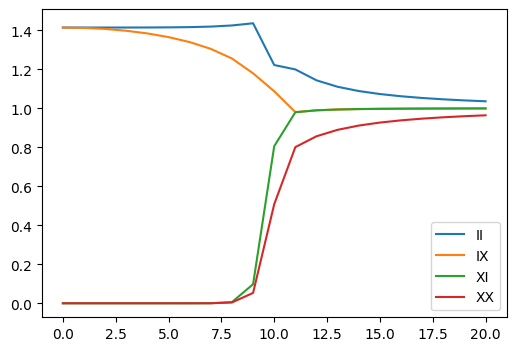

In [141]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(scores_array):
    ax.plot(x, label=symmetry_labels[i])

ax.legend()

fig.show()

Why is the score decreasing for the identity action in the trivial phase? The singular value is changing, as previously observed.

### Distances

In [142]:
distances_array = np.array(distances).T

In [143]:
np.max(distances_array[:3])

(4.440892098500626e-16+0j)

In [144]:
np.max(distances_array[4:])

(5.561319188718272e-05+0j)

In [145]:
distances_array[3]

array([ 2.96332019e-01+0.j,  9.23501475e-06+0.j,  4.05899348e-02+0.j,
        7.21999987e-05+0.j,  1.95833243e-08+0.j,  1.00364161e-13+0.j,
        0.00000000e+00+0.j,  1.99840144e-15+0.j,  1.04019016e-11+0.j,
        1.78165782e-06+0.j,  1.06165567e+00+0.j,  4.44089210e-16+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
       -4.44089210e-16+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j])

/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


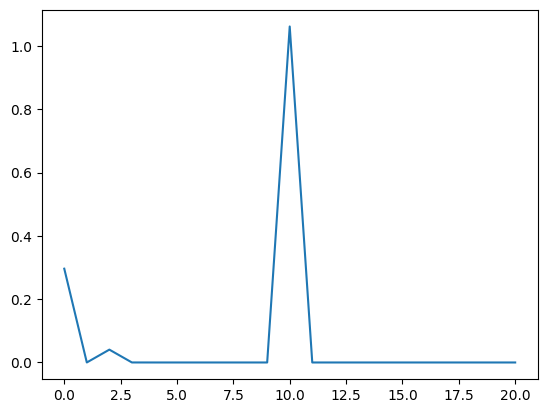

In [146]:
plt.plot(distances_array[3])

Getting an error precisely where the SPT phase above changes, the same B-strength and group elements, $XI$ and $IX$.

### Unitaries

In [147]:
unitaries_array = np.round(np.array([[u.to_ndarray() for u in l] for l in unitaries]), 3)

In [148]:
unitaries_array.shape

(21, 4, 2, 2)

In [149]:
unitaries_array[:, 0]

array([[[-1.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j]],

       [[-1.+0

In [150]:
unitaries_array[:, 1]

array([[[-1.   +0.j,  0.   +0.j],
        [ 0.   +0.j,  1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j]],

       [[-1.   +0.j, -0.   +0.j],
        [-0.   +0.j,  1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j]],

       [[-1.   +0.j,  0.   +0.j],
        [ 0.   +0.j,  1.   +0.j]],

       [[ 1.   +0.j,  0.   +0.j],
        [ 0.   +0.j, -1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j]],

       [[-0.931+0.j, -0.364+0.j],
        [-0.364+0.j,  0.931+0.j]],

       [[-1.   +0.j, -0.   +0.j],
        [ 0.   +0.j, -1.   +0.j]],

       [[-1.   +0.j,  0.   +0.j],
        [ 0.   +0.j, -1.   +0.j]],

       [[-1.   +0.j, -0.   +0.j],
        [ 0.   +0.j, -1.   +0.j]],

       [[-1.   +0.j,

In [151]:
unitaries_array[:, 2]

array([[[-0.192+0.j, -0.981+0.j],
        [-0.981+0.j,  0.192+0.j]],

       [[-1.   +0.j, -0.001+0.j],
        [ 0.001+0.j, -1.   +0.j]],

       [[ 0.071+0.j, -0.997+0.j],
        [-0.997+0.j, -0.071+0.j]],

       [[ 0.003+0.j, -1.   +0.j],
        [-1.   +0.j, -0.003+0.j]],

       [[ 0.   +0.j,  1.   +0.j],
        [ 1.   +0.j, -0.   +0.j]],

       [[ 0.   +0.j,  1.   +0.j],
        [ 1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[ 0.   +0.j, -1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[ 0.   +0.j, -1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[ 0.   +0.j, -1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[ 0.   +0.j,

In [152]:
unitaries_array[:, 3]

array([[[-0.   +0.j,  1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[ 0.003+0.j, -1.   +0.j],
        [ 1.   +0.j,  0.003+0.j]],

       [[ 0.   +0.j,  1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[ 0.   +0.j,  1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[-0.   +0.j,  1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [ 1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [ 1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j,  1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [ 1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [ 1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j,  1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[-0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j]],

       [[ 0.   +0.j, -1.   +0.j],
        [-1.   +0.j, -0.   +0.j]],

       [[ 0.   +0.j,

So in trivial phase, have $I, I, I, I/X$ and for the non-trivial phase have $I, Z, Z, iY$

The flipping in the trivial phase of the $XX$ term is odd.

In [153]:
unitaries_array[9]

array([[[-1.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[ 1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]],

       [[ 0.+0.j, -1.+0.j],
        [-1.+0.j, -0.+0.j]],

       [[-0.+0.j, -1.+0.j],
        [ 1.+0.j, -0.+0.j]]])

Would taking a longer patch for the symmetry action fix this?

### Longer patch for odd case

In [154]:
psi_dict.keys()

dict_keys([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])

In [155]:
longer_cases = [
    SymmetryActionWithBoundaryUnitaries(
        psi_dict[0.9],
        s*80,
        left_boundary_unitaries=[np_I,]*3,
        right_boundary_unitaries=[np_I,]*3
    )
    for s in symmetry_actions
]

In [156]:
for c in longer_cases:
    c.compute_svd_approximate_expectation()

In [157]:
score_unitary_pairs = [get_unitary(c) for c in longer_cases]

In [158]:
scores = [p[0] for p in score_unitary_pairs]
unitaries = [p[1] for p in score_unitary_pairs]

In [159]:
phase_distance_pairs = [gauge_invariant_phase(*p) for p in combinations(unitaries, 2)]

In [160]:
phases = [p[0] for p in phase_distance_pairs]
distances = [p[1] for p in phase_distance_pairs]

In [161]:
phases

[(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)]

In [162]:
[u.to_ndarray() for u in unitaries]

[array([[-1.00000000e+00+0.j,  3.24821461e-16+0.j],
        [-1.32642367e-16+0.j, -1.00000000e+00+0.j]]),
 array([[ 0.99999944+0.j, -0.00106179+0.j],
        [-0.00106179+0.j, -0.99999944+0.j]]),
 array([[ 1.23087451e-04+0.j, -9.99999992e-01+0.j],
        [-9.99999992e-01+0.j, -1.23087451e-04+0.j]]),
 array([[-7.10542736e-15+0.j,  1.00000000e+00+0.j],
        [-1.00000000e+00+0.j, -6.99440506e-15+0.j]])]

Still having issues... perhaps the solution did not converge...?

### Right projected symmetry states

In [163]:
right_symmetry_states = [[
    np.round(c.right_projected_symmetry_state.to_ndarray())
    for c in l] for l in cases]

In [164]:
right_symmetry_states[0]

[array([[-1.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j]]),
 array([[ 0.+0.j,  1.+0.j],
        [ 1.+0.j, -0.+0.j]]),
 array([[-1.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j]]),
 array([[-0.+0.j, -1.+0.j],
        [ 1.+0.j,  0.+0.j]])]

In [165]:
np.array(right_symmetry_states[1])[:, :3, :3]

array([[[-1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -0.+0.j]],

       [[ 0.+0.j,  1.+0.j,  0.+0.j],
        [ 1.+0.j, -0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j]],

       [[-1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j,  0.+0.j],
        [-1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]]])

In [166]:
np.array(right_symmetry_states[5])[:, :3, :3]

array([[[-1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j]],

       [[-0.+0.j, -1.+0.j, -0.+0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j,  0.+0.j]],

       [[-0.+0.j,  1.+0.j,  0.+0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j,  0.+0.j]]])

In [167]:
np.array(right_symmetry_states[8])[:, :3, :3]

array([[[-1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-0.+0.j,  1.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j]],

       [[-1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j,  1.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -0.+0.j]],

       [[ 0.+0.j, -1.+0.j,  0.+0.j],
        [ 1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]]])

In [168]:
np.array(right_symmetry_states[9])[:, :3, :3]

array([[[-1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -0.+0.j]],

       [[-0.+0.j, -1.+0.j, -0.+0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j]],

       [[-1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  1.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-0.+0.j,  1.+0.j, -0.+0.j],
        [-1.+0.j, -0.+0.j,  0.+0.j],
        [ 0.+0.j, -0.+0.j, -0.+0.j]]])

In [169]:
np.array(right_symmetry_states[10])[:, :3, :3]

array([[[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-1.+0.j, -1.+0.j, -0.+0.j],
        [-1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j]],

       [[-1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-0.+0.j,  1.+0.j, -0.+0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j]]])

In [170]:
np.array(right_symmetry_states[11])[:, :3, :3]

array([[[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-1.+0.j, -0.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j]],

       [[-1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j]]])

In [171]:
np.array(right_symmetry_states[15])[:, :3, :3]

array([[[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j]],

       [[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j,  0.+0.j]],

       [[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j,  0.+0.j, -0.+0.j]],

       [[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j]]])

Right symmetry states very regular, more than I remember...

Fixed a bug in the code where I was solving for the wrong site (the one immediately to the left, so the site "behind" the symmetry action. This introduced errors for small B! So definitely _not_ translationally invariant, and possible room for improvement?

## Two site unitaries

In [216]:
score_unitary_pairs = [[get_2_site_unitary(c) for c in l] for l in cases]

In [217]:
scores = [[p[0] for p in l] for l in score_unitary_pairs]
unitaries = [[p[1] for p in l] for l in score_unitary_pairs]

In [218]:
unitaries[0][0]

<npc.Array shape=(4, 4) labels=['p', 'p*']>

In [219]:
identity_u = unitaries[0][0].copy()

In [220]:
for i in range(4):
    for j in range(4):
        c = 1 if i == j else 0
        identity_u[i,j] = c

In [221]:
identity_u.to_ndarray()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [222]:
phase_distance_pairs = [[gauge_invariant_phase(*p, dim=4) for p in combinations(l, 2)] for l in unitaries]

In [223]:
phases = [[p[0] for p in l] for l in phase_distance_pairs]
distances = [[p[1] for p in l] for l in phase_distance_pairs]

### Phases

In [224]:
len(phases)

21

In [225]:
phases[:10]

[[(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-0.9999999999999999+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-0.9999999999999999+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-0.9999999999999999+0j), (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-0.9999999999999999+0j), (-1+0j)],
 [(1+0j),
  (1+0j),
  (1+0j),
  (0.9999999999999999+0j),
  (-0.9999999999999999+0j),
  (-1+0j)],
 [(1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j), (-1+0j)]]

In [226]:
phases[10]

[(1+0j), (1+0j), (1+0j), (1+0j), (-1+0j), (-1+0j)]

In [227]:
phases[11:]

[[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)],
 [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]]

### Scores

In [228]:
scores_array = np.array(scores).T

In [229]:
scores_array

array([[1.41421356e+00, 1.41421468e+00, 1.41423197e+00, 1.41431178e+00,
        1.41454875e+00, 1.41512287e+00, 1.41638434e+00, 1.41906654e+00,
        1.42490333e+00, 1.43609004e+00, 1.22193043e+00, 1.19941782e+00,
        1.14350954e+00, 1.11037774e+00, 1.08855503e+00, 1.07315463e+00,
        1.06174660e+00, 1.05298879e+00, 1.04607899e+00, 1.04050777e+00,
        1.03593590e+00],
       [1.41421356e+00, 1.41297022e+00, 1.40976082e+00, 1.39967238e+00,
        1.41170989e+00, 1.40723506e+00, 1.40710250e+00, 1.39538600e+00,
        1.35063213e+00, 1.38828738e+00, 1.15259220e+00, 9.80540906e-01,
        9.89685739e-01, 9.93978145e-01, 9.96077917e-01, 9.97323839e-01,
        9.98093568e-01, 9.98596041e-01, 9.98942146e-01, 9.99179550e-01,
        9.99354300e-01],
       [9.22541232e-01, 1.18166962e+00, 1.10895598e+00, 1.30709990e+00,
        2.68563674e-03, 2.73265668e-04, 7.10413503e-02, 1.02140669e-01,
        7.35278065e-03, 1.07370800e-01, 9.05416808e-01, 1.08607193e+00,
        9.8968

/tmp/ipykernel_15782/408976895.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


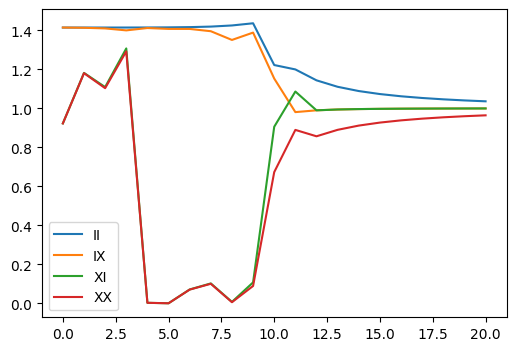

In [230]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(scores_array):
    ax.plot(x, label=symmetry_labels[i])

ax.legend()

fig.show()

### Distances

In [231]:
distances_array = np.array(distances).T

In [233]:
np.max(distances_array)

(8.000000000000005+0j)

/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_15782/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


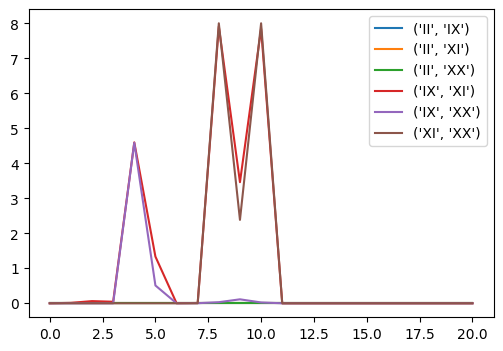

In [237]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

Worse projective representation in places.

### Unitaries

In [238]:
unitaries_array = np.round(np.array([[u.to_ndarray() for u in l] for l in unitaries]), 3)

In [239]:
unitaries_array.shape

(21, 4, 4, 4)

In [240]:
unitaries_array[0, 0]

array([[-1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
       [-0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
       [ 0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [241]:
unitaries_array[0, 1]

array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j],
       [ 0.+0.j, -0.+0.j,  0.+0.j,  1.+0.j]])

In [242]:
gauge_invariant_phase(unitaries[0][0], unitaries[0][1], dim=4)

((1+0j), (-8.881784197001252e-16+0j))

In [249]:
unitaries_array[0]

array([[[-1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j,  1.+0.j]],

       [[-0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j,  1.+0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j, -1.+0.j],
        [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j, -0.+0.j, -0.+0.j]]])

In [243]:
unitaries_array[:, 0]

array([[[-1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -1.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j]],

       [[-1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j]],

       [[-1.+0.j, -0.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j, -1.+0.

In [244]:
unitaries_array[:, 1]

array([[[-1.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
        [-0.   +0.j, -1.   +0.j,  0.   +0.j, -0.   +0.j],
        [ 0.   +0.j,  0.   +0.j,  1.   +0.j, -0.   +0.j],
        [ 0.   +0.j, -0.   +0.j,  0.   +0.j,  1.   +0.j]],

       [[ 1.   +0.j, -0.   +0.j, -0.027+0.j, -0.   +0.j],
        [-0.   +0.j,  1.   +0.j, -0.   +0.j,  0.027+0.j],
        [-0.027+0.j, -0.   +0.j, -1.   +0.j, -0.   +0.j],
        [-0.   +0.j,  0.027+0.j, -0.   +0.j, -1.   +0.j]],

       [[ 0.998+0.j,  0.   +0.j, -0.062+0.j, -0.   +0.j],
        [ 0.   +0.j,  0.998+0.j,  0.001+0.j,  0.062+0.j],
        [-0.062+0.j,  0.001+0.j, -0.998+0.j,  0.   +0.j],
        [-0.   +0.j,  0.062+0.j,  0.   +0.j, -0.998+0.j]],

       [[-0.999+0.j, -0.   +0.j,  0.053+0.j,  0.002+0.j],
        [-0.   +0.j, -0.999+0.j, -0.002+0.j, -0.053+0.j],
        [ 0.053+0.j, -0.002+0.j,  0.999+0.j, -0.   +0.j],
        [ 0.002+0.j, -0.053+0.j, -0.   +0.j,  0.999+0.j]],

       [[ 0.985+0.j, -0.018+0.j,  0.174+0.j,  0.004+0.j],
      

In [245]:
unitaries_array[:, 2]

array([[[-0.   +0.j,  0.   +0.j, -1.   +0.j,  0.   +0.j],
        [ 0.   +0.j, -0.   +0.j,  0.   +0.j,  1.   +0.j],
        [-1.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
        [ 0.   +0.j,  1.   +0.j,  0.   +0.j,  0.   +0.j]],

       [[-0.   +0.j,  0.   +0.j,  1.   +0.j, -0.   +0.j],
        [ 0.   +0.j,  0.   +0.j, -0.   +0.j, -1.   +0.j],
        [ 1.   +0.j, -0.   +0.j,  0.   +0.j,  0.   +0.j],
        [-0.   +0.j, -1.   +0.j,  0.   +0.j, -0.   +0.j]],

       [[ 0.   +0.j, -0.001+0.j,  1.   +0.j,  0.   +0.j],
        [-0.001+0.j, -0.   +0.j,  0.   +0.j, -1.   +0.j],
        [ 1.   +0.j,  0.   +0.j, -0.   +0.j, -0.001+0.j],
        [ 0.   +0.j, -1.   +0.j, -0.001+0.j,  0.   +0.j]],

       [[ 0.   +0.j,  0.002+0.j, -1.   +0.j, -0.   +0.j],
        [ 0.002+0.j, -0.   +0.j, -0.   +0.j,  1.   +0.j],
        [-1.   +0.j, -0.   +0.j, -0.   +0.j,  0.002+0.j],
        [-0.   +0.j,  1.   +0.j,  0.002+0.j,  0.   +0.j]],

       [[-0.179+0.j,  0.848+0.j, -0.465+0.j, -0.18 +0.j],
      

In [246]:
unitaries_array[:, 3]

array([[[ 0.   +0.j,  0.   +0.j,  1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -0.   +0.j, -0.   +0.j, -1.   +0.j],
        [-1.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
        [ 0.   +0.j,  1.   +0.j, -0.   +0.j, -0.   +0.j]],

       [[ 0.   +0.j, -0.   +0.j, -1.   +0.j,  0.   +0.j],
        [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  1.   +0.j],
        [ 1.   +0.j, -0.   +0.j,  0.   +0.j, -0.   +0.j],
        [-0.   +0.j, -1.   +0.j,  0.   +0.j,  0.   +0.j]],

       [[ 0.   +0.j,  0.   +0.j, -1.   +0.j, -0.   +0.j],
        [-0.   +0.j, -0.   +0.j, -0.   +0.j,  1.   +0.j],
        [ 1.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
        [ 0.   +0.j, -1.   +0.j, -0.   +0.j,  0.   +0.j]],

       [[ 0.   +0.j,  0.   +0.j,  1.   +0.j,  0.   +0.j],
        [-0.   +0.j,  0.   +0.j,  0.   +0.j, -1.   +0.j],
        [-1.   +0.j, -0.   +0.j, -0.   +0.j,  0.   +0.j],
        [-0.   +0.j,  1.   +0.j, -0.   +0.j,  0.   +0.j]],

       [[-0.   +0.j,  0.878+0.j, -0.442+0.j, -0.183+0.j],
      

In [247]:
unitaries_array[9]

array([[[-1.   +0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j],
        [-0.   +0.j, -1.   +0.j,  0.   +0.j, -0.   +0.j],
        [ 0.   +0.j, -0.   +0.j, -1.   +0.j,  0.   +0.j],
        [ 0.   +0.j,  0.   +0.j, -0.   +0.j, -1.   +0.j]],

       [[ 0.853+0.j,  0.522+0.j, -0.005+0.j,  0.003+0.j],
        [ 0.522+0.j, -0.852+0.j,  0.019+0.j, -0.005+0.j],
        [-0.005+0.j,  0.019+0.j,  0.846+0.j, -0.532+0.j],
        [ 0.003+0.j, -0.005+0.j, -0.532+0.j, -0.847+0.j]],

       [[ 0.115+0.j, -0.047+0.j, -0.854+0.j, -0.504+0.j],
        [-0.047+0.j, -0.176+0.j,  0.502+0.j, -0.845+0.j],
        [-0.854+0.j,  0.502+0.j, -0.081+0.j, -0.105+0.j],
        [-0.504+0.j, -0.845+0.j, -0.105+0.j,  0.142+0.j]],

       [[-0.   +0.j, -0.   +0.j, -0.597+0.j, -0.802+0.j],
        [ 0.   +0.j, -0.   +0.j,  0.802+0.j, -0.597+0.j],
        [ 0.597+0.j, -0.802+0.j,  0.   +0.j,  0.   +0.j],
        [ 0.802+0.j,  0.597+0.j, -0.   +0.j, -0.   +0.j]]])

## Conclusion

Don't seem to gain much by adding a new site, in fact it perhaps makes things worse?